---
execute:
  echo: true
  enabled: false
  output: true
  warning: false
format:
    html:
        code-fold: false
---

## Detect malware

The model deployment is done in two stages: I. tune the model, II. turn on the malware detection (on the data collected in B1 and B2 periods respectively, described in the timeline @fig-timeline)

![Timeline](../../imgs/timeline.png)

### Model selection

In experiment I we have seen that the model "RF normed-2-4-0-0" performed better than others. We will use this model in the current experiment.

Model description

 - Random Forest classification model
 - Normalization with RobustClassifier is enabled
 - Model skips first 2 packets and next 4 packets are weighted for packet sizes statistics calculation

### Stage I: Model tuning

On this state we fit the scaler on the data collected in B1 period, to be used later on the second stage

In [1]:
#| echo: false
#| output: false
basepath = "/home/u1/"

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
from detect_common import *

In [4]:
#| output: false
p1version = "v6"
p2version = "v7"
p3version = "v9"
p3version_exp1 = "v5"

In [5]:
model = 'RF'
normed = True
skips_and_weights = [2,4,0,0]

In [6]:
import dateutil.parser

df_b1 = pd.read_feather("cached/v9_1.ft")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

2023-03-27 18:02:52,568 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-im_2_mls', purging
2023-03-27 18:02:52,569 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5fdwvhv3', purging
2023-03-27 18:02:52,569 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-s0w2vgft', purging
2023-03-27 18:02:52,569 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cu23kb1m', purging
2023-03-27 18:02:52,570 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fwxpci6b', purging
2023-03-27 18:02:52,570 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-70qpguwq', p

In [7]:
path_doh_ips_androids = basepath + "datasets/flubot20230323/data/v5_benign_doh_ips.csv"
path_doh_ips_general = "doh_resolver_ip.csv"
full_list = get_doh_ips(path_doh_ips_androids) + get_doh_ips(path_doh_ips_general)

cp = CacheableProcessing(100, 100, full_list)
df_b1_p = cp.process(df_b1, f"cached/v9_1.p3.{p3version}.cp.ft")

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
Reason: `lines` argument not supported


In [8]:
from joblib import dump, load

name = (
    ('normed-' if normed else 'unnormed-') + 
    '-'.join(str(p) for p in skips_and_weights)
)

clf = load(f'models/{model}-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib')
model, name

('RF', 'normed-2-4-0-0')

In [9]:
results_df = pd.read_feather(f"cached/robustness.balanced_mix-results.p3.{p3version_exp1}.ft")
results_df["skips_and_weights"] = results_df["skips_and_weights"].apply(str)
model, normed, skips_and_weights_str, auc, fprs, tprs, thresholds = results_df[
    (results_df["model"] == model) & (results_df["normed"] == normed) & (results_df["skips_and_weights"] == str(np.array(skips_and_weights)))
].iloc[0]

In [10]:
pp_b1 = PreProcessing(normed, *skips_and_weights)

df_b1_pp = pp_b1.process(
    df_b1_p,
    f"cached/p3.{p3version}.pp.{model}-{name}.saved", 
    fit_new_scaler=True
)

Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported


In [11]:
if not os.path.exists(f"cached/p3.{p3version}.pp.{model}-{name}.scaler"):
    pp_b1.store_scaler(
        f"cached/p3.{p3version}.pp.{model}-{name}.scaler"
    )

In [12]:
local_ips = df_b1[df_b1["ipaddr SRC_IP"].str.startswith("192.168")]["ipaddr SRC_IP"].unique().tolist()
local_ips

2023-03-27 18:03:18,610 - distributed.worker - ERROR - Exception during execution of task lambda-3d886e2246bce7db16e51cf0551a9d79.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-ce29b3a6-591e-4de3-9b7c-bb4877d296de'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

['192.168.2.149', '192.168.2.217', '192.168.2.42']

In [13]:
def predict(pp, clf, threshold, df_pp, df_orig):
    """
    pp: PreProcessing object
    clf: classifier
    threshold: >=threshold for positive (DoH) class
    df_pp: preprocessed dataframe
    df_orig: unprocessed dataframe
    """
    df_pp2 = df_pp.copy()

    df_pp2["IsDoHPredicted"] = (clf.predict_proba(df_pp2[pp.feature_fields])[:,1] >= threshold).astype(bool)

    df_orig2 = df_orig.copy()
    # fill predicted to the original dataframe
    df_orig2["IsDoHPredicted"] = df_pp2["IsDoHPredicted"]
    # non-443 rows will be NaN, replace with False
    df_orig2["IsDoHPredicted"] = df_orig2["IsDoHPredicted"].fillna(False)

    return df_orig2


In [14]:
def calc(df_n):
    def rate(df_h):
        dns_packets = df_h[df_h["IsDoHPredicted"] == True]["uint32 PACKETS"].sum()  # outgoing packets
        non_dns_ips = set(
            df_h[df_h["IsDoHPredicted"] == False]["ipaddr SRC_IP"].unique()
        ).union(
            # src and dst IPs could be stored in a reverse way.
            # since number of internal IPs is limited, it's safe to account them all
            set(
                df_h[df_h["IsDoHPredicted"] == False]["ipaddr DST_IP"].unique()
            )
        )
        rate = float(dns_packets) / (1.0 + len(non_dns_ips))
        return {
            "dns_packets": dns_packets,
            "non_dns": len(non_dns_ips),
            "rate": rate,
            "rate_log": np.log(rate)
        }

    return pd.DataFrame(
        { ip: rate(grp) for ip, grp in df_n.groupby(["ipaddr SRC_IP"]) }
    ).T.reset_index()


#### Build time-series forecast models for each host

In [15]:
freq = "2min"

behavior_ips_sens = {}

for sensitivity in [0.8, 0.9]:  #, 0.95]:
    print(sensitivity)
    threshold = [threshold for tpr, threshold in zip(tprs, thresholds) if tpr >= sensitivity][0]

    min_ts = df_b1["time TIME_FIRST"].apply(dateutil.parser.parse).min()

    df_b1_pp_df = df_b1_pp[0]
    behavior_ips = {}
    for ip in local_ips:
        print(ip)
        df_b1_ip_pp = df_b1_pp_df[df_b1_pp_df["ipaddr SRC_IP"] == ip]
        if len(df_b1_ip_pp) == 0:
            continue
        #df_b1_ip_pp["time TIME_FIRST"] = df_b1_ip_pp["time TIME_FIRST"].apply(dateutil.parser.parse)
        # df_b1_ip_pp = df_b1_ip_pp.set_index("time TIME_FIRST")
        df_b1_ip_pp_pred = predict(
            pp_b1, clf, threshold, df_b1_ip_pp, df_b1[df_b1["ipaddr SRC_IP"] == ip]
        )

        df_b1_ip_pp_pred["time TIME_FIRST"] = df_b1_ip_pp_pred["time TIME_FIRST"].apply(dateutil.parser.parse)
        # ignore last 5 mins
        df_b1_ip_pp_pred_max = df_b1_ip_pp_pred["time TIME_FIRST"].max()  # - pd.Timedelta(minutes=5)
        df_b1_ip_pp_pred = df_b1_ip_pp_pred[df_b1_ip_pp_pred["time TIME_FIRST"] < df_b1_ip_pp_pred_max]
        
        df_b1_ip_pp_pred = df_b1_ip_pp_pred.set_index(["time TIME_FIRST"])

        df_resample = df_b1_ip_pp_pred.groupby(pd.Grouper(freq=freq, origin=min_ts)).first()
        times = df_resample.index.tolist()
        ranges = list(zip(times, times[1:]))

        df_calcs = []
        for ran in ranges:
            df_ran = df_b1_ip_pp_pred[(df_b1_ip_pp_pred.index > ran[0]) & (df_b1_ip_pp_pred.index < ran[1])]
            df_calc = calc(df_ran)
            df_calc["ts"] = ran[0]
            df_calcs.append(df_calc)

        behavior_ips[ip] = df_calcs

    behavior_ips_sens[sensitivity] = behavior_ips


0.8
192.168.2.149


2023-03-27 18:03:22,266 - distributed.worker - ERROR - Exception during execution of task lambda-f80ae5dbfdd92ea814ab9fbde5c52434.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-5b3180b5-f7ba-499f-a805-f19f3a82b267'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

192.168.2.217


2023-03-27 18:05:28,624 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:05:32,517 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:05:35,288 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:05:36,725 - distributed.worker - ERROR - Exception during execution of task lambda-45bbb6495a7a4f243e11935cca86a641.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-a9fa6556-e729-4a3d-bee3-148bd0d1bc4

192.168.2.42
0.9
192.168.2.149


2023-03-27 18:07:33,821 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:07:38,758 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:07:42,074 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:07:44,350 - distributed.worker - ERROR - Exception during execution of task lambda-fed2ca7666a83c9660b8e1077c6f3d86.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-07e86e74-9947-4848-8700-bdc23e29cc8

192.168.2.217


2023-03-27 18:09:36,828 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:09:41,904 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:09:45,865 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:09:46,885 - distributed.worker - ERROR - Exception during execution of task lambda-b5768a8b9d0a6145cd7963968d7d247b.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-3eb85edb-a7fc-4e62-a8a1-06cc4bfeb48

192.168.2.42


In [16]:
from statsmodels.tsa.arima.model import ARIMA

forecast_models = {}  # (sensitivity, ip addr) => time-series forecasting model
window_size = 10

def moving_average(x, w):
    # https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    return np.convolve(x, np.ones(w), 'valid') / w


for sens, behavior_ips in behavior_ips_sens.items():
    for ip, data_ips in behavior_ips.items():
        rate_logs = np.array([
            item["rate_log"][0] if len(item) else 0.0
            for item in data_ips
        ])
        forecast_model = ARIMA(
            # rate_logs
            moving_average(rate_logs, window_size)
        ).fit()
        forecast_models[(sens, ip)] = forecast_model

### Stage II: Malware detection

On this state we turn on the malware detection, provisioning the model with the scaler trained before. For malware detection we use the data trained in B2 period.

In [17]:
df_b2 = pd.read_feather("cached/v9_2.ft")

In [18]:
cp = CacheableProcessing(100, 100, full_list)
df_b2_p = cp.process(df_b2, f"cached/v9_2.p3.{p3version}.cp.ft")

Reason: `lines` argument not supported
2023-03-27 18:11:48,135 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:11:49,015 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:11:50,071 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:11:50,977 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [19]:
pp_b2 = PreProcessing(normed, *skips_and_weights)
pp_b2.load_scaler(
    f"cached/p3.{p3version}.pp.{model}-{name}.scaler"
)
assert pp_b2._scaler
df_b2_pp, df_b2_pp_features, df_b2_pp_labels = pp_b2.process(
    df_b2_p,
    f"cached/b2.p3.{p3version}.pp.{model}-{name}.saved", 
    fit_new_scaler=False  # use scaler trained in B1
)

Reason: `lines` argument not supported
2023-03-27 18:11:59,085 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:12:00,145 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:12:01,062 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
Reason: `lines` argument not supported
Reason: `lines` argument not supported


In [39]:
min_ts = df_b2["time TIME_FIRST"].apply(dateutil.parser.parse).min()
infection_ts = min_ts + pd.Timedelta(minutes=62) - pd.Timedelta(freq) * window_size
min_ts, infection_ts

(Timestamp('2023-03-27 08:11:28.503294'),
 Timestamp('2023-03-27 08:53:28.503294'))

In [21]:
data = {}
for sensitivity in [0.8, 0.9]:  #, 0.95]:
    threshold = [threshold for tpr, threshold in zip(tprs, thresholds) if tpr >= sensitivity][0]
    df_pred = predict(pp_b2, clf, threshold, df_b2_pp, df_b2)

    data[sensitivity] = {
        'df': df_pred,  # dataframe with predicted values,
        'threshold': threshold,
    }


2023-03-27 18:12:27,005 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


#### Calculate ratio on the whole dataset: benign period (A1) and infected (A2)

In [22]:
for sensitivity, value in data.items():
    print(sensitivity)
    df_pred = value["df"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")]

    local_df["time TIME_FIRST"] = local_df["time TIME_FIRST"].apply(dateutil.parser.parse)

    local_df_a1 = local_df[local_df["time TIME_FIRST"] < infection_ts]
    local_df_a2 = local_df[local_df["time TIME_FIRST"] >= infection_ts]

    print("sensitivity:", sensitivity, "A1")
    display(calc(local_df_a1))
    print("sensitivity:", sensitivity, "A2")
    display(calc(local_df_a2))



0.8


2023-03-27 18:12:33,589 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:12:38,733 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:12:45,595 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:12:51,858 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


sensitivity: 0.8 A1


2023-03-27 18:12:57,024 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:13:04,039 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:13:11,770 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


,index,dns_packets,non_dns,rate,rate_log
0,192.168.2.149,79451.0,2058.0,38.587178,3.652920
1,192.168.2.217,64126.0,1748.0,36.664380,3.601806
2,192.168.2.42,0.0,3.0,0.000000,-inf


sensitivity: 0.8 A2


2023-03-27 18:13:19,158 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-27 18:13:19,665 - distributed.worker - ERROR - Exception during execution of task lambda-ae591af684c4aca8bb187526ba3b0a1c.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-3f9a411e-eec4-4ca7-8997-caf2a40a21dc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_executi

,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.000000,-inf
1,192.168.2.149,53922.0,1524.0,35.358689,3.565544
2,192.168.2.217,146060.0,1816.0,80.385250,4.386831
3,192.168.2.42,0.0,4.0,0.000000,-inf


0.9


2023-03-27 18:14:30,791 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:14:36,609 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:14:37,988 - distributed.worker - WARNING - Could not find data: {'function-61230ce5a4754b5db449a5e94f7854a2': ['tcp://127.0.0.1:38047', 'tcp://127.0.0.1:36627', 'tcp://127.0.0.1:45613']} on workers: [] (who_has: {'function-61230ce5a4754b5db449a5e94f7854a2': ['tcp://127.0.0.1:38047', 'tcp://127.0.0.1:36627', 'tcp://127.0.0.1:45613']})
2023-03-27 18:14:37,989 - distributed.scheduler - WARNING - Worker tcp://127.0.0.1:46563 failed to acquire keys: {'function-61230ce5a4754b5db449a5e94f7854a2': ('tcp://127.0.0.1:38047', 'tcp://127.0.0.1:36627', 'tcp://127.0.0.1:45613')}
2023-03-27 18:14:45,034 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:14:49,716 

sensitivity: 0.9 A1


2023-03-27 18:14:56,058 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:02,981 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:05,436 - distributed.worker - ERROR - Exception during execution of task lambda-edf1919602f3a90504bd43fe11a1458d.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-2be444a2-2f0b-4555-99d3-e5912d0275c7'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib

,index,dns_packets,non_dns,rate,rate_log
0,192.168.2.149,92981.0,1961.0,47.390928,3.858431
1,192.168.2.217,76559.0,1692.0,45.220910,3.811560
2,192.168.2.42,0.0,3.0,0.000000,-inf


sensitivity: 0.9 A2


2023-03-27 18:15:26,560 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:32,974 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:39,616 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:47,665 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:15:51,241 - distributed.worker - ERROR - Exception during execution of task lambda-bec6d129aebf320b3c1b968f0290f9cb.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-pa

,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.000000,-inf
1,192.168.2.149,65813.0,1457.0,45.139232,3.809752
2,192.168.2.217,418387.0,1730.0,241.702484,5.487708
3,192.168.2.42,0.0,4.0,0.000000,-inf


#### Split into time windows

In [23]:
local_ips = df_b2[df_b2["ipaddr SRC_IP"].str.startswith("192.168")]["ipaddr SRC_IP"].unique().tolist()
local_ips

2023-03-27 18:16:34,563 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


['192.168.2.149', '192.168.2.217', '192.168.2.42', '192.168.1.1']

In [24]:
for sensitivity, value in data.items():
    print(sensitivity)

    df_pred = value["df"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")].copy()
    local_df["time TIME_FIRST"] = local_df["time TIME_FIRST"].apply(dateutil.parser.parse)

    calc_ips = {}

    a1_t = local_df.set_index(["time TIME_FIRST"])

    df_resample = a1_t.groupby(pd.Grouper(freq=freq, origin=min_ts)).first()
    times = df_resample.index.tolist()
    ranges = list(zip(times, times[1:]))

    df_calcs = []
    for ran in ranges:
        df_ran = a1_t[(a1_t.index > ran[0]) & (a1_t.index < ran[1])]
        df_calc = calc(df_ran)
        df_calc["ts"] = ran[0]
        df_calcs.append(df_calc)

    value["df_calc"] = pd.concat(df_calcs).reset_index(drop=True)

0.8


2023-03-27 18:16:41,422 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:16:47,881 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:16:55,255 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:17:01,051 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:17:08,541 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-27 18:17:09,086 - distributed.worker - ERROR - Exception during execution of task lambda-fba2fc73dc082eb329ad8639883f1b0b.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-pack

0.9


2023-03-27 18:23:50,769 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-27 18:23:57,529 - distributed.worker - ERROR - Exception during execution of task lambda-9cb9d9ec9a9b3bab5c55022939366418.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-2be51380-cc8b-44e0-af7d-f7906e2a07b6'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_executi

In [25]:
clean = "192.168.2.149"
infected = "192.168.2.217"

We are using use ARIMA model to calculate confidence interval upper limit for outlier (malware) detection

0.8


2023-03-27 20:11:08,409 - distributed.worker - ERROR - Exception during execution of task lambda-3b0e702c9c9a830a2035008a9ef3f068.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-f105d994-2267-4b1a-a165-094c75f992bf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

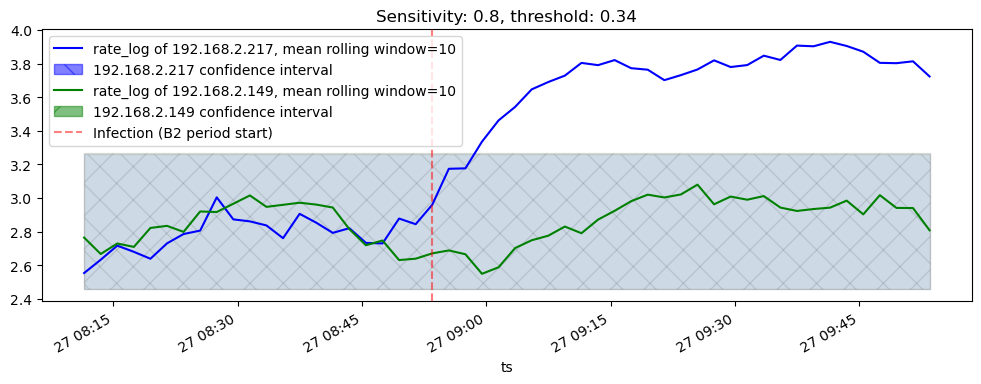

0.9


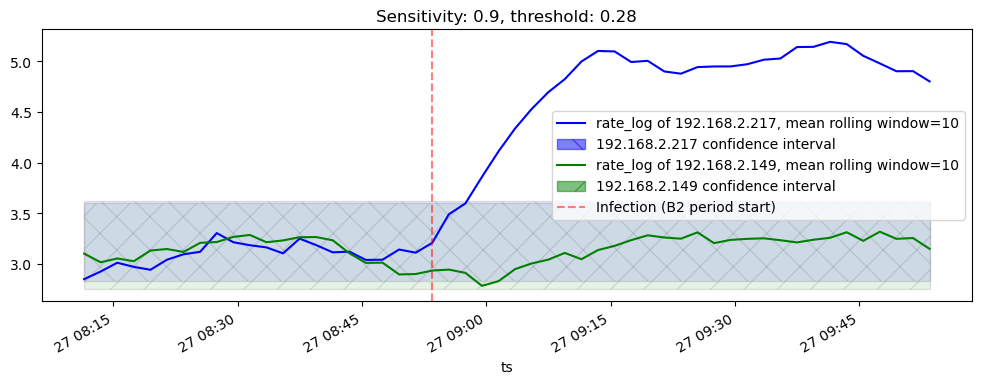

In [59]:
#| label: fig-real-world-flubot-detection-1
#| fig-cap: $\rho(a)$ plot for clean and infected instances (B2 period)
#| fig-subcap: 
#|   - "sensitivity 0.8"
#|   - "sensitivity 0.9"

import matplotlib.pyplot as plt

for sensitivity, value in data.items():
    print(sensitivity)
    fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
    df_calcs = value["df_calc"]

    df_calcs_clean = df_calcs[df_calcs["index"] == clean].set_index("ts")
    df_calcs_infected = df_calcs[df_calcs["index"] == infected].set_index("ts")
    for host, df, color, hatch in zip(
        [infected, clean], 
        [df_calcs_infected, df_calcs_clean], 
        ['blue', 'green'],
        ['\\', '/'],
    ):
        df_avgd = df.copy()
        df_avgd_array = moving_average(df["rate_log"], window_size)
        rate_log_ser = pd.Series(df_avgd_array, index=df_avgd["rate_log"].index[:len(df_avgd_array)])

        rate_log_ser.plot(
            label=f'rate_log of {host}, mean rolling window={window_size}',
            ax=axs, color=color
        )
        if (sensitivity, host) in forecast_models:
            forecast_model = forecast_models[(sensitivity, host)]
            forecast = forecast_model.get_forecast(len(rate_log_ser))

            yhat_conf_int = forecast.conf_int(alpha=0.05)
            under_line = [v[0] for v in yhat_conf_int]
            over_line = [v[1] for v in yhat_conf_int]
            plt.fill_between(
                rate_log_ser.index, under_line,
                over_line, color=color, alpha=.1,
                hatch=hatch, edgecolor='black'
            )
            plt.fill(
                np.NaN, np.NaN, color=color, alpha=0.5,
                label=f'{host} confidence interval', hatch=hatch
            )

    plt.axvline(
        x=infection_ts, label="Infection (B2 period start)", color="red", linestyle='--', alpha=0.5
    )

    # plt.ylim(ymin=0)
    plt.title(f"Sensitivity: {sensitivity}, threshold: {value['threshold']}")
    plt.legend()
    plt.show()